In [1]:
## Keras for deep learning
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#for logging
import time

##matrix math
import math

##plotting
import matplotlib.pyplot as plt
from sklearn import preprocessing

from numpy import loadtxt
from keras.models import load_model
import pandas as pd
import os
import numpy as np
import time
import datetime

##matrix math
import math


os.chdir('D:/Graduate Courses/2019 Dissertation/Data/Other.coins')
print("Current Working Directory " , os.getcwd())


Using TensorFlow backend.


Current Working Directory  D:\Graduate Courses\2019 Dissertation\Data\Other.coins


In [2]:
# %load LSTM2
#!/usr/bin/env python

# In[1]:


def load_data(filename, window_length,percent):
    """
    Loads the bitcoin data
    
    Arguments:
    filename -- A string that represents where the .csv file can be located
    sequence_length -- An integer of how many days should be looked at in a row
    percent -- how many percent of data used to train the model
    
    Returns:
    if window=30
    X_train -- A tensor of shape (2492, 30, 105) that will be inputed into the model to train it
    Y_train -- A tensor of shape (2492,) that will be inputed into the model to train it
    X_test -- A tensor of shape (623, 30, 105) that will be used to test the model's proficiency
    Y_test -- A tensor of shape (623,) that will be used to check the model's predictions
    Y_daybefore -- A tensor of shape (623,) that represents the price of bitcoin the day before each Y_test value
    """
    
    #Read the data file
    dataset_total = pd.read_csv(filename,na_values='n/a',parse_dates=['Date'])
    dataset_total=dataset_total.drop(['Unnamed: 0',], axis=1)

    # Set index
    dataset_total.set_index('Date', inplace=True)
    dataset_total= dataset_total.loc[:, (dataset_total!= 0).any(axis=0)]

    #normalize dataset
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    dataset_total_scaled = sc.fit_transform(dataset_total)
    X_normal=dataset_total_scaled[:,:-1]
    Y=dataset_total_scaled[:,-1]
    
   
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    data = X_normal.tolist()
    result = []
    for index in range(len(data) - window_length):
        result.append(data[index: index + window_length])

    data_reshape=np.array(result)
    data_reshape.shape

    #Splitting data set into training (First 80% of data points) and testing data (last 20% of data points)
    split_line = round(percent* data_reshape.shape[0])
    X_train = data_reshape[:int(split_line), :]
    Y_train = Y[window_length:int(split_line)+window_length]
    X_test = data_reshape[int(split_line):,:]
    Y_test = Y[int(split_line)+window_length:]
    Y_daybefore = Y[int(split_line)+window_length-1:-1]
   
    #new
    line=int(split_line)+window_length
    return X_train, Y_train, X_test, Y_test, window_length,dataset_total,Y_daybefore,line


def initialize_model(dropout_rate):
    """
    Initializes and creates the model to be used
    
    Arguments:
    dropout_rate -- A decimal representing how much dropout should be incorporated at each level, in this case 0.2
    activation_function -- A string to define the activation_function, in this case it is linear
    loss_function -- A string to define the loss function to be used, in the case it is mean squared error
    optimizer -- A string to define the optimizer to be used, in the case it is adam
    
    Returns:
    model -- A 3 layer RNN with 100*dropout_value dropout in each layer that uses activation_function as its activation
             function, loss_function as its loss function, and optimizer as its optimizer
    """
  
    #Build the model
    model=Sequential()

    input_shape=(window_length, X_train.shape[-1])

    optimizer='adam'
    loss='mean_squared_error'
    
    model.add(LSTM(units = 32, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units = 32, return_sequences = False))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units = 1))
    model.compile(optimizer =optimizer, loss = loss)

    
    return model


#Training the model

def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2492, 30, 105) that represents the x values of the training data
    Y_train -- A tensor of shape (2492,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 100
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
   

    #Train the model on X_train and Y_train
    model.fit(X_train, Y_train, batch_size= batch_num, nb_epoch=num_epoch, validation_split= val_split)

    return model


# test the model
def test_model(model, X_test, Y_test):
    """
    Test the model on the testing data
    
    Arguments:
    model -- The previously fitted 3 layer Recurrent Neural Network
    X_test -- A tensor of shape (623, 30, 105) that represents the x values of the testing data
    Y_test -- A tensor of shape (623,) that represents the y values of the testing data
    unnormalized_bases -- A tensor of shape (623,) that can be used to get unnormalized data points
    
    Returns:
    y_predict -- A tensor of shape (623,) that represnts the normalized values that the model predicts based on X_test
    real_y_test -- A tensor of shape (623,) that represents the actual prices of bitcoin throughout the testing period
    real_y_predict -- A tensor of shape (623,) that represents the model's predicted prices of bitcoin
    fig -- A branch of the graph of the real predicted prices of bitcoin versus the real prices of bitcoin
    """
    #Test the model on X_Test
    Y_norm = model.predict(X_test)
    
    # normalize predicted y
    Y_original=dataset_total.iloc[:,-1]
    Y_max=Y_original.max()
    Y_min=Y_original.min()
    real_y_predict = Y_norm *(Y_max-Y_min)+Y_min
    
    # normalize Y_test
    real_y_test = Y_test *(Y_max-Y_min)+Y_min
    
    # normalize real Y_daybefore
    real_y_daybefore = Y_daybefore * (Y_max-Y_min)+Y_min

    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("Real and Predicted Return Over Time")
    plt.plot(real_y_predict, color = 'green', label = 'Predicted Return')
    plt.plot(real_y_test, color = 'red', label = 'Real Return')
    ax.set_ylabel("Return")
    ax.set_xlabel("Time (Days)")
    ax.legend()
    plt.style.use('ggplot')
    plt.show()
    return Y_norm, real_y_test, real_y_predict, fig, real_y_daybefore


#evaluate change in return

def return_change(real_y_daybefore, real_y_test, real_y_predict):
    """
    Calculate the percent change between each value and the day before
    
    Arguments:
    real_y_daybefore -- A tensor of shape (623,) that represents the prices of each day before each price in Y_test
    Y_test -- A tensor of shape (623,) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (623,) that represents the normalized y values of the model's predictions
    
    Returns:
    delta_predict -- A tensor of shape (623, ) that represents the difference between predicted and day before values
    delta_real -- A tensor of shape (623, ) that represents the difference between real and day before values
    fig -- A plot representing percent change in bitcoin price per day,
    """
    return_change_real = real_y_test - real_y_daybefore
    real_y_predict_reshape= np.reshape(real_y_predict,(real_y_predict.shape[0],))
    return_change_predict = real_y_predict_reshape - real_y_daybefore

    fig_2 = plt.figure(figsize=(10, 6))
    ax = fig_2.add_subplot(111)
    ax.set_title("Change in Real and Predicted Return Per Day")
    plt.plot(return_change_predict, color='green', label = 'Predicted Return Change')
    plt.plot(return_change_real, color='red', label = 'Real Return Change')
    plt.ylabel("Return Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.style.use('ggplot')
    plt.show()
    return  return_change_predict, return_change_real, fig_2

def binary_return(return_change_predict,return_change_real):
    """
    Converts return change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    Arguments:
    delta_predict -- A tensor of shape (623, 1) that represents the predicted percent change in price
    delta_real -- A tensor of shape (623, 1) that represents the real percent change in price
    
    Returns:
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    return_change_predict_1_0 = np.empty(return_change_predict.shape)
    return_change_real_1_0 = np.empty(return_change_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(return_change_predict.shape[0]):
        if return_change_predict[i] > 0:
            return_change_predict_1_0[i] = 1
        else:
            return_change_predict_1_0[i] = 0
  
    for i in range(return_change_real.shape[0]):
        if  return_change_real[i] > 0:
            return_change_real_1_0[i] = 1
        else:
            return_change_real_1_0[i] = 0
    return return_change_predict_1_0, return_change_real_1_0


def find_positives_negatives(return_change_predict_1_0, return_change_real_1_0):
    """
    Finding the number of false positives, false negatives, true positives, true negatives
    
    Arguments: 
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    
    Returns:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    """
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(return_change_real_1_0.shape[0]):
        real = return_change_real_1_0[i]
        predicted = return_change_predict_1_0[i]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg


# In[ ]:

def classify_range(variable_name):
    
    classification[variable_name+'_range']=0

    for i in range(classification.shape[0]):
        if classification[variable_name][i]<=0.002 and classification[variable_name][i]>=-0.002:
            classification[variable_name+'_range'][i]=0
        
        elif classification[variable_name][i]<=-0.002 and classification[variable_name][i]>=-0.004:
            classification[variable_name+'_range'][i]=-1
        
        elif classification[variable_name][i]<=-0.004 and classification[variable_name][i]>=-0.006:
            classification[variable_name+'_range'][i]=-2
        
        elif classification[variable_name][i]<=-0.006 and classification[variable_name][i]>=-0.008:
            classification[variable_name+'_range'][i]=-3
        
        elif classification[variable_name][i]<=-0.008 and classification[variable_name][i]>=-0.010:
            classification[variable_name+'_range'][i]=-4
        
        elif classification[variable_name][i]<=-0.010 and classification[variable_name][i]>=-0.012:
            classification[variable_name+'_range'][i]=-5
        
        elif classification[variable_name][i]<=-0.012 and classification[variable_name][i]>=-0.014:
            classification[variable_name+'_range'][i]=-6
        
        elif classification[variable_name][i]<=-0.014 and classification[variable_name][i]>=-0.016:
            classification[variable_name+'_range'][i]=-7
        
        elif classification[variable_name][i]<=-0.016 and classification[variable_name][i]>=-0.018:
            classification[variable_name+'_range'][i]=-8
        
        elif classification[variable_name][i]<=-0.018 and classification[variable_name][i]>=-0.020:
            classification[variable_name+'_range'][i]=-9
        
        elif classification[variable_name][i]<=-0.020:
            classification[variable_name+'_range'][i]=-10
        
        #positive value
        elif classification[variable_name][i]<=0.004 and classification[variable_name][i]>=0.002:
            classification[variable_name+'_range'][i]=1
        
        elif classification[variable_name][i]<=0.006 and classification[variable_name][i]>=0.004:
            classification[variable_name+'_range'][i]=2
        
        elif classification[variable_name][i]<=0.008 and classification[variable_name][i]>=0.006:
            classification[variable_name+'_range'][i]=3
        
        elif classification[variable_name][i]<=0.010 and classification[variable_name][i]>=0.008:
            classification[variable_name+'_range'][i]=4
        
        elif classification[variable_name][i]<=0.012 and classification[variable_name][i]>=0.010:
            classification[variable_name+'_range'][i]=5
        
        elif classification[variable_name][i]<=0.014 and classification[variable_name][i]>=0.012:
            classification[variable_name+'_range'][i]=6
        
        elif classification[variable_name][i]<=0.016 and classification[variable_name][i]>=0.014:
            classification[variable_name+'_range'][i]=7
        
        elif classification[variable_name][i]<=0.018 and classification[variable_name][i]>=0.016:
            classification[variable_name+'_range'][i]=8
        
        elif classification[variable_name][i]<=0.020 and classification[variable_name][i]>=0.018:
            classification[variable_name+'_range'][i]=9
         
        else:
            classification[variable_name+'_range'][i]=10
    return classification

def find_the_successful_rate(classification):
    successful_number=0
    for i in range(classification.shape[0]):
        if classification['real_y_test_range'][i]==classification['real_y_predict_range'][i]:
            successful_number+=1
    successful_rate=round(successful_number/classification.shape[0],4)
    return successful_rate





(2934, 30, 73)
(2934,)
(180, 30, 73)
(180,)
30
(180,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 32)            13568     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 21,921
Trainable pa

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2347 samples, validate on 587 samples
Epoch 1/100
2347/2347 [==============================] - 3s 1ms/step - loss: 0.0034 - val_loss: 0.0176
Epoch 2/100
2347/2347 [==============================] - 1s 537us/step - loss: 0.0014 - val_loss: 0.0123
Epoch 3/100
2347/2347 [==============================] - 1s 568us/step - loss: 0.0011 - val_loss: 0.0078
Epoch 4/100
2347/2347 [==============================] - 1s 538us/step - loss: 9.6022e-04 - val_loss: 0.0052
Epoch 5/100
2347/2347 [==============================] - 1s 570us/step - loss: 8.8974e-04 - val_loss: 0.0045
Epoch 6/100
2347/2347 [==============================] - 1s 598us/step - loss: 8.0564e-04 - val_loss: 0.0042
Epoch 7/100
2347/2347 [==============================] - 1s 568us/step - loss: 7.6662e-04 - val_loss: 0.0034
Epoch 8/100
2347/2347 [==============================] - 1s 523us/step - loss: 7.5680e-04 - val_loss: 0.0021
Epoch 9/100
2347/2347 [==============================] - 1s 566us/step - loss: 7.4089e-04 - val

2347/2347 [==============================] - 1s 586us/step - loss: 5.3656e-04 - val_loss: 2.6267e-04
Epoch 74/100
2347/2347 [==============================] - 1s 591us/step - loss: 5.2947e-04 - val_loss: 2.0847e-04
Epoch 75/100
2347/2347 [==============================] - 1s 586us/step - loss: 5.8086e-04 - val_loss: 2.2246e-04
Epoch 76/100
2347/2347 [==============================] - 1s 585us/step - loss: 5.4697e-04 - val_loss: 2.4360e-04
Epoch 77/100
2347/2347 [==============================] - 1s 585us/step - loss: 5.4557e-04 - val_loss: 2.8460e-04
Epoch 78/100
2347/2347 [==============================] - 1s 591us/step - loss: 5.2634e-04 - val_loss: 2.2883e-04
Epoch 79/100
2347/2347 [==============================] - 1s 611us/step - loss: 5.3956e-04 - val_loss: 1.7045e-04
Epoch 80/100
2347/2347 [==============================] - 1s 603us/step - loss: 5.8866e-04 - val_loss: 2.2713e-04
Epoch 81/100
2347/2347 [==============================] - 1s 612us/step - loss: 5.7030e-04 - val_loss

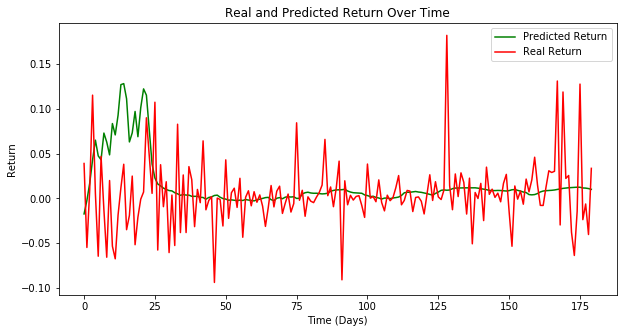

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:340: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-24     0.038930       -0.017407                 10   
2018-11-25    -0.054833       -0.002312                -10   
2018-11-26     0.010146        0.016987                  5   
2018-11-27     0.115240        0.042899                 10   
2018-11-28     0.005427        0.064981                  2   
2018-11-29    -0.064623        0.047423                -10   
2018-11-30     0.046834        0.043076                 10   
2018-12-01    -0.012770        0.072900                 -6   
2018-12-02    -0.065748        0.062803                -10   
2018-12-03     0.019897        0.048562                  9   
2018-12-04    -0.053416        0.083533                -10   
2018-12-05    -0.067518        0.070845                -10   
2018-12-06    -0.018538        0.092862                 -9   
2018-12-07     0.011840        0.126971                  5   
2018-12-

C:\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


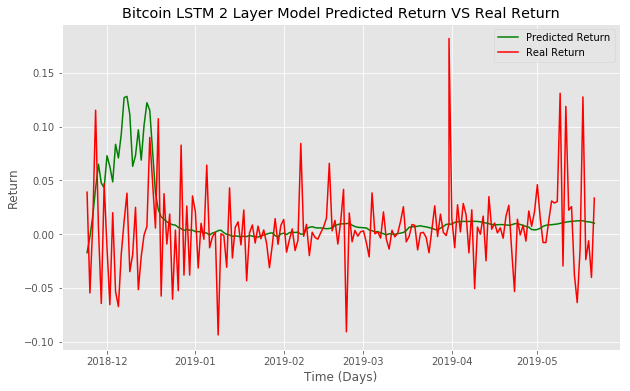

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

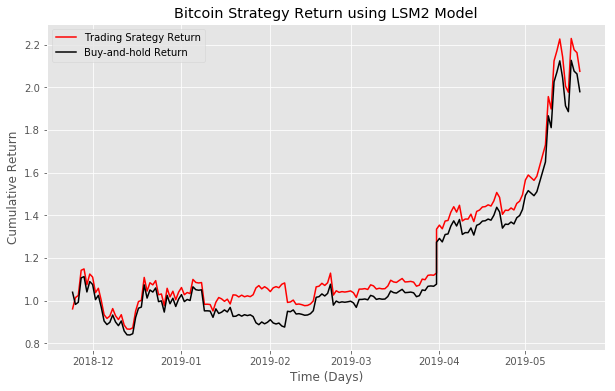

Annulized Sharpe Ratio is 1.1760439972388066
Annulized Sharpe Ratio for buy and hold strategy is 1.0620883732767286


In [3]:
#Compile together
#Bitcoin
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("Bitcoin_revised.csv", 30, 0.9422)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .2)


#save the model
model.save("Bitcoin_model.h5")

# load model
#model = load_model('Bitcoin_model.h5')

#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("Bitcoin LSTM 2 Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

classification.head(10)
test_set=pd.DataFrame(classification['real_y_predict_range'])
type(test_set)
test_set.columns=['classification_predict']
test_set['Price']=dataset_total['Adj Close'][line:]
test_set['Position']=0

for i in range(test_set.shape[0]):
    if test_set['classification_predict'][i]<0:
        test_set['Position'][i]=-1
    elif test_set['classification_predict'][i]==0:
        test_set['Position'][i]=test_set['Position'][i-1]
    else:
        test_set['Position'][i]=1
test_set['daily_return']=test_set['Price'].pct_change()
test_set['daily_return']=test_set['daily_return'].shift(-1)
test_set['strategy_daily_return']=test_set['Position']*test_set['daily_return']
test_set=test_set.dropna()
test_set['buy_cumulative_return']=1
test_set=test_set.dropna()
test_set['buy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['buy_cumulative_return'][i]=test_set['daily_return'][i]+1
    else:
        test_set['buy_cumulative_return'][i]=(test_set['daily_return'][i]+1)* test_set['buy_cumulative_return'][i-1]

test_set['strategy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['strategy_cumulative_return'][i]=test_set['strategy_daily_return'][i]+1
    else:
        test_set['strategy_cumulative_return'][i]=(test_set['strategy_daily_return'][i]+1)* test_set['strategy_cumulative_return'][i-1]

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("Bitcoin Strategy Return using LSM2 Model")
plt.plot(test_set['strategy_cumulative_return'], color='red', label = 'Trading Srategy Return')
plt.plot(test_set['buy_cumulative_return'], color='black', label = 'Buy-and-hold Return')
plt.ylabel("Cumulative Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

#calculate trading strategy sharpe ratio
risk_free_rate=0.002

test_set['excess_return']=test_set['strategy_daily_return']-risk_free_rate
test_set['excess_return'].std()
test_set['excess_return'].mean()
daily_sharpe=test_set['excess_return'].mean()/test_set['excess_return'].std()
print('Annulized Sharpe Ratio is '+str(daily_sharpe*252**0.5))

#calculate buy and hold sharpe ratio
test_set['excess_return_buy']=test_set['daily_return']-risk_free_rate
test_set['excess_return_buy'].std()
test_set['excess_return_buy'].mean()
daily_sharpe_2=test_set['excess_return_buy'].mean()/test_set['excess_return_buy'].std()
print('Annulized Sharpe Ratio for buy and hold strategy is '+str(daily_sharpe_2*252**0.5))

Sharpe=pd.DataFrame(test_set['excess_return_buy'])
Sharpe['excess_return_str']=test_set['excess_return']

####rename for each cryptocurrency
Sharpe.to_csv('Sharpe_LSTM2_Bit.csv')



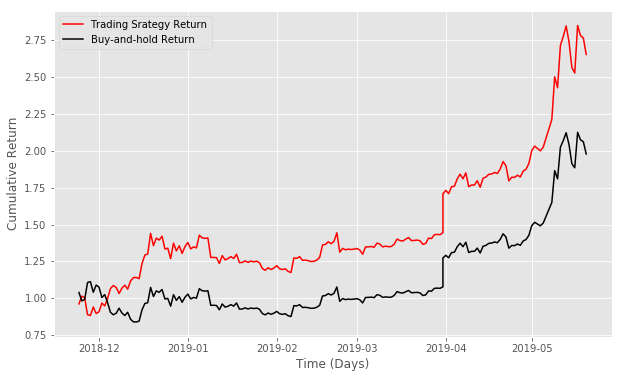

In [28]:
fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
plt.plot(test_set['strategy_cumulative_return'], color='red', label = 'Trading Srategy Return')
plt.plot(test_set['buy_cumulative_return'], color='black', label = 'Buy-and-hold Return')
plt.ylabel("Cumulative Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

In [21]:
test_set['excess_return']=test_set['strategy_daily_return']-risk_free_rate
test_set['excess_return'].std()
test_set['excess_return'].mean()
daily_sharpe=test_set['excess_return'].mean()/test_set['excess_return'].std()
print('Annulized Sharpe Ratio is '+str(daily_sharpe*252**0.5))

Sharpe=pd.DataFrame(test_set['excess_return_buy'])
Sharpe['excess_return_str']=test_set['excess_return_buy']

####rename for each cryptocurrency
Sharpe.to_csv('Bit_Sharpe.csv')


Annulized Sharpe Ratio is 1.7738939618863727


(1740, 30, 108)
(1740,)
(180, 30, 108)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30, 32)            18048     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 26,401
Trainable params: 26,401
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1218 samples, validate on 522 samples
Epoch 1/100
1218/1218 [==============================] - 3s 3ms/step - loss: 0.0171 - val_loss: 0.0017
Epoch 2/100
1218/1218 [==============================] - 1s 834us/step - loss: 0.0053 - val_loss: 0.0015
Epoch 3/100
1218/1218 [==============================] - 1s 819us/step - loss: 0.0036 - val_loss: 0.0030
Epoch 4/100
1218/1218 [==============================] - 1s 847us/step - loss: 0.0033 - val_loss: 0.0017
Epoch 5/100
1218/1218 [==============================] - 1s 838us/step - loss: 0.0031 - val_loss: 0.0015
Epoch 6/100
1218/1218 [==============================] - 1s 836us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 7/100
1218/1218 [==============================] - 1s 843us/step - loss: 0.0027 - val_loss: 0.0017
Epoch 8/100
1218/1218 [==============================] - 1s 827us/step - loss: 0.0028 - val_loss: 0.0021
Epoch 9/100
1218/1218 [==============================] - 1s 863us/step - loss: 0.0025 - val_loss: 0.0017
Epoch 10/1

Epoch 78/100
1218/1218 [==============================] - 1s 806us/step - loss: 0.0013 - val_loss: 0.0025
Epoch 79/100
1218/1218 [==============================] - 1s 806us/step - loss: 0.0013 - val_loss: 0.0033
Epoch 80/100
1218/1218 [==============================] - 1s 820us/step - loss: 0.0013 - val_loss: 0.0031
Epoch 81/100
1218/1218 [==============================] - 1s 822us/step - loss: 0.0013 - val_loss: 0.0035
Epoch 82/100
1218/1218 [==============================] - 1s 818us/step - loss: 0.0013 - val_loss: 0.0039
Epoch 83/100
1218/1218 [==============================] - 1s 826us/step - loss: 0.0013 - val_loss: 0.0040
Epoch 84/100
1218/1218 [==============================] - 1s 799us/step - loss: 0.0013 - val_loss: 0.0039
Epoch 85/100
1218/1218 [==============================] - 1s 815us/step - loss: 0.0013 - val_loss: 0.0035
Epoch 86/100
1218/1218 [==============================] - 1s 824us/step - loss: 0.0013 - val_loss: 0.0036
Epoch 87/100
1218/1218 [======================

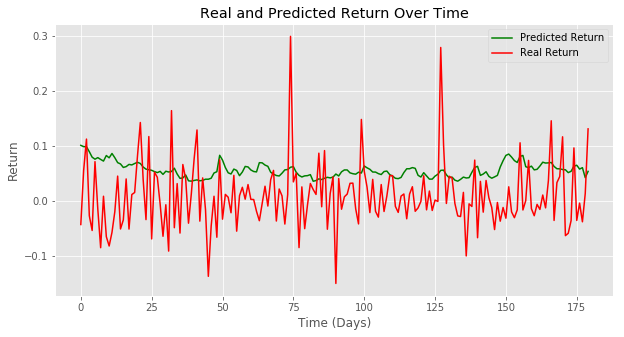

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:340: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.043450        0.100999                -10   
2018-11-26     0.055254        0.098679                 10   
2018-11-27     0.112432        0.098378                 10   
2018-11-28    -0.027433        0.089403                -10   
2018-11-29    -0.054335        0.079417                -10   
2018-11-30     0.071272        0.075781                 10   
2018-12-01    -0.015826        0.078634                 -7   
2018-12-02    -0.085765        0.075347                -10   
2018-12-03     0.008143        0.072304                  4   
2018-12-04    -0.065590        0.082425                -10   
2018-12-05    -0.082642        0.078249                -10   
2018-12-06    -0.057671        0.086191                -10   
2018-12-07    -0.020000        0.078443                 -9   
2018-12-08     0.044898        0.069483                 10   
2018-12-

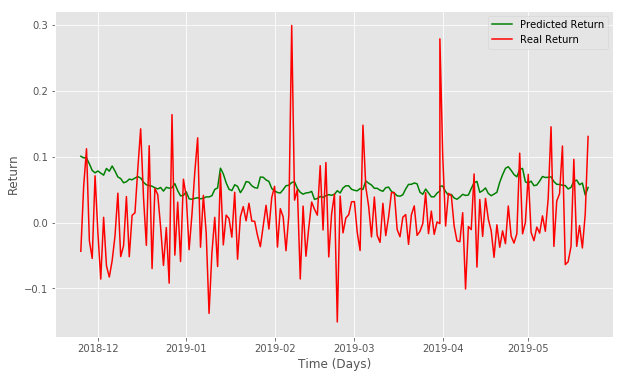

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

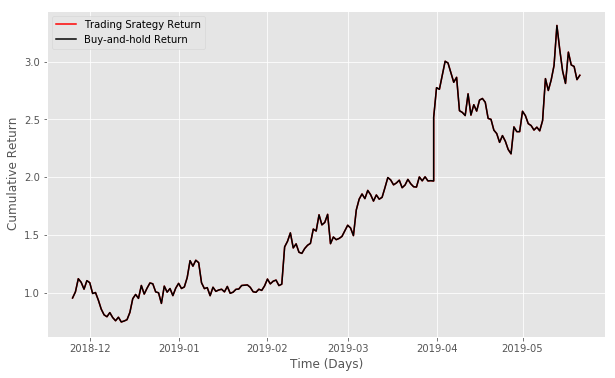

Annulized Sharpe Ratio is 1.4936024962189969
Annulized Sharpe Ratio for buy and hold strategy is 1.4936024962189969


In [6]:
#Compile together
#LTC
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_LTC-USD.csv", 30, 0.9063)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

classification.head(10)
test_set=pd.DataFrame(classification['real_y_predict_range'])
type(test_set)
test_set.columns=['classification_predict']
test_set['Price']=dataset_total['Adj Close'][line:]
test_set['Position']=0

for i in range(test_set.shape[0]):
    if test_set['classification_predict'][i]<0:
        test_set['Position'][i]=-1
    elif test_set['classification_predict'][i]==0:
        test_set['Position'][i]=test_set['Position'][i-1]
    else:
        test_set['Position'][i]=1
test_set['daily_return']=test_set['Price'].pct_change()
test_set['daily_return']=test_set['daily_return'].shift(-1)
test_set['strategy_daily_return']=test_set['Position']*test_set['daily_return']
test_set=test_set.dropna()
test_set['buy_cumulative_return']=1
test_set=test_set.dropna()
test_set['buy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['buy_cumulative_return'][i]=test_set['daily_return'][i]+1
    else:
        test_set['buy_cumulative_return'][i]=(test_set['daily_return'][i]+1)* test_set['buy_cumulative_return'][i-1]

test_set['strategy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['strategy_cumulative_return'][i]=test_set['strategy_daily_return'][i]+1
    else:
        test_set['strategy_cumulative_return'][i]=(test_set['strategy_daily_return'][i]+1)* test_set['strategy_cumulative_return'][i-1]

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
plt.plot(test_set['strategy_cumulative_return'], color='red', label = 'Trading Srategy Return')
plt.plot(test_set['buy_cumulative_return'], color='black', label = 'Buy-and-hold Return')
plt.ylabel("Cumulative Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

#calculate trading strategy sharpe ratio
risk_free_rate=0.002

test_set['excess_return']=test_set['strategy_daily_return']-risk_free_rate
test_set['excess_return'].std()
test_set['excess_return'].mean()
daily_sharpe=test_set['excess_return'].mean()/test_set['excess_return'].std()
print('Annulized Sharpe Ratio is '+str(daily_sharpe*252**0.5))

#calculate buy and hold sharpe ratio
test_set['excess_return_buy']=test_set['daily_return']-risk_free_rate
test_set['excess_return_buy'].std()
test_set['excess_return_buy'].mean()
daily_sharpe_2=test_set['excess_return_buy'].mean()/test_set['excess_return_buy'].std()
print('Annulized Sharpe Ratio for buy and hold strategy is '+str(daily_sharpe_2*252**0.5))

Sharpe=pd.DataFrame(test_set['excess_return_buy'])
Sharpe['excess_return_str']=test_set['excess_return']

####rename for each cryptocurrency
Sharpe.to_csv('Sharpe_LSTM2_LTC.csv')



(1286, 30, 110)
(1286,)
(180, 30, 110)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 30, 32)            18304     
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 26,657
Trainable params: 26,657
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 386 samples
Epoch 1/100
900/900 [==============================] - 4s 5ms/step - loss: 0.0100 - val_loss: 0.0042
Epoch 2/100
900/900 [==============================] - ETA: 0s - loss: 0.006 - 1s 810us/step - loss: 0.0059 - val_loss: 0.0019
Epoch 3/100
900/900 [==============================] - 1s 969us/step - loss: 0.0056 - val_loss: 0.0023
Epoch 4/100
900/900 [==============================] - 1s 895us/step - loss: 0.0045 - val_loss: 0.0021
Epoch 5/100
900/900 [==============================] - 1s 834us/step - loss: 0.0046 - val_loss: 0.0021
Epoch 6/100
900/900 [==============================] - 1s 815us/step - loss: 0.0043 - val_loss: 0.0020
Epoch 7/100
900/900 [==============================] - 1s 829us/step - loss: 0.0051 - val_loss: 0.0026
Epoch 8/100
900/900 [==============================] - 1s 828us/step - loss: 0.0042 - val_loss: 0.0016
Epoch 9/100
900/900 [==============================] - 1s 893us/step - loss: 0.0039 - val_loss: 0.0016
Epoch

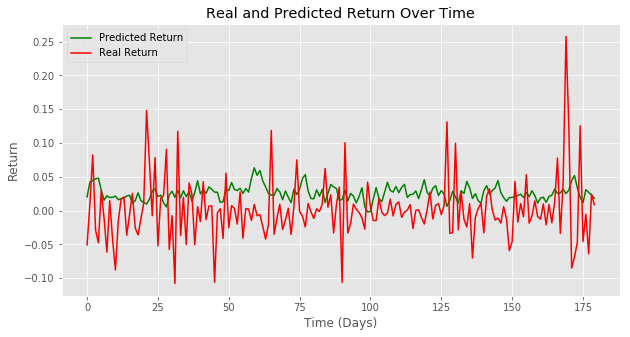

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:340: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.050767        0.020105                -10   
2018-11-26     0.010028        0.041930                  5   
2018-11-27     0.082460        0.044628                 10   
2018-11-28    -0.028790        0.047066                -10   
2018-11-29    -0.047744        0.047995                -10   
2018-11-30     0.029477        0.030584                 10   
2018-12-01    -0.011239        0.015404                 -5   
2018-12-02    -0.061434        0.021868                -10   
2018-12-03     0.014706        0.019390                  7   
2018-12-04    -0.042342        0.019603                -10   
2018-12-05    -0.087834        0.021652                -10   
2018-12-06    -0.016591        0.016064                 -8   
2018-12-07     0.016871        0.017481                  8   
2018-12-08     0.020169        0.018780                 10   
2018-12-

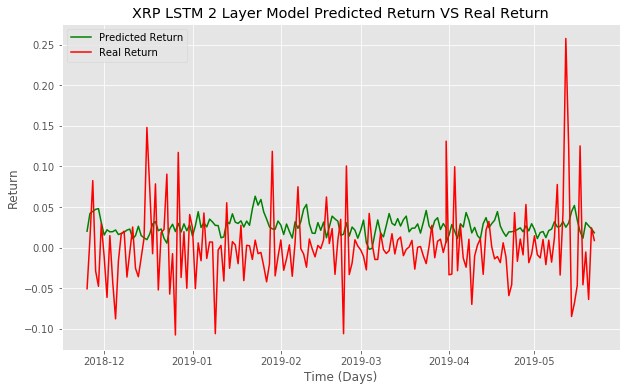

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

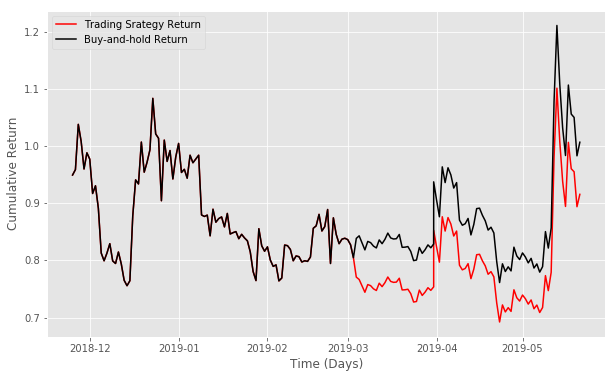

Annulized Sharpe Ratio is -0.5041157838726804
Annulized Sharpe Ratio for buy and hold strategy is -0.32246454698985777


In [12]:
#Compile together
#XRP
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_XRP-USD.csv", 30, 0.8773)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("XRP LSTM 2 Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

classification.head(10)
test_set=pd.DataFrame(classification['real_y_predict_range'])
type(test_set)
test_set.columns=['classification_predict']
test_set['Price']=dataset_total['Adj Close'][line:]
test_set['Position']=0

for i in range(test_set.shape[0]):
    if test_set['classification_predict'][i]<0:
        test_set['Position'][i]=-1
    elif test_set['classification_predict'][i]==0:
        test_set['Position'][i]=test_set['Position'][i-1]
    else:
        test_set['Position'][i]=1
test_set['daily_return']=test_set['Price'].pct_change()
test_set['daily_return']=test_set['daily_return'].shift(-1)
test_set['strategy_daily_return']=test_set['Position']*test_set['daily_return']
test_set=test_set.dropna()
test_set['buy_cumulative_return']=1
test_set=test_set.dropna()
test_set['buy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['buy_cumulative_return'][i]=test_set['daily_return'][i]+1
    else:
        test_set['buy_cumulative_return'][i]=(test_set['daily_return'][i]+1)* test_set['buy_cumulative_return'][i-1]

test_set['strategy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['strategy_cumulative_return'][i]=test_set['strategy_daily_return'][i]+1
    else:
        test_set['strategy_cumulative_return'][i]=(test_set['strategy_daily_return'][i]+1)* test_set['strategy_cumulative_return'][i-1]

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
plt.plot(test_set['strategy_cumulative_return'], color='red', label = 'Trading Srategy Return')
plt.plot(test_set['buy_cumulative_return'], color='black', label = 'Buy-and-hold Return')
plt.ylabel("Cumulative Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

#calculate trading strategy sharpe ratio
risk_free_rate=0.002

test_set['excess_return']=test_set['strategy_daily_return']-risk_free_rate
test_set['excess_return'].std()
test_set['excess_return'].mean()
daily_sharpe=test_set['excess_return'].mean()/test_set['excess_return'].std()
print('Annulized Sharpe Ratio is '+str(daily_sharpe*252**0.5))

#calculate buy and hold sharpe ratio
test_set['excess_return_buy']=test_set['daily_return']-risk_free_rate
test_set['excess_return_buy'].std()
test_set['excess_return_buy'].mean()
daily_sharpe_2=test_set['excess_return_buy'].mean()/test_set['excess_return_buy'].std()
print('Annulized Sharpe Ratio for buy and hold strategy is '+str(daily_sharpe_2*252**0.5))

Sharpe=pd.DataFrame(test_set['excess_return_buy'])
Sharpe['excess_return_str']=test_set['excess_return']

####rename for each cryptocurrency
Sharpe.to_csv('Sharpe_LSTM2_XRP.csv')

(640, 30, 112)
(640,)
(180, 30, 112)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 32)            18560     
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 448 samples, validate on 192 samples
Epoch 1/100
448/448 [==============================] - 3s 6ms/step - loss: 0.0268 - val_loss: 0.0039
Epoch 2/100
448/448 [==============================] - 0s 762us/step - loss: 0.0138 - val_loss: 0.0035
Epoch 3/100
448/448 [==============================] - 0s 760us/step - loss: 0.0106 - val_loss: 0.0034
Epoch 4/100
448/448 [==============================] - 0s 802us/step - loss: 0.0105 - val_loss: 0.0036
Epoch 5/100
448/448 [==============================] - 0s 749us/step - loss: 0.0102 - val_loss: 0.0034
Epoch 6/100
448/448 [==============================] - 0s 761us/step - loss: 0.0111 - val_loss: 0.0034
Epoch 7/100
448/448 [==============================] - 0s 787us/step - loss: 0.0094 - val_loss: 0.0034
Epoch 8/100
448/448 [==============================] - 0s 772us/step - loss: 0.0102 - val_loss: 0.0033
Epoch 9/100
448/448 [==============================] - 0s 724us/step - loss: 0.0088 - val_loss: 0.0035
Epoch 10/100
448/448 [=======

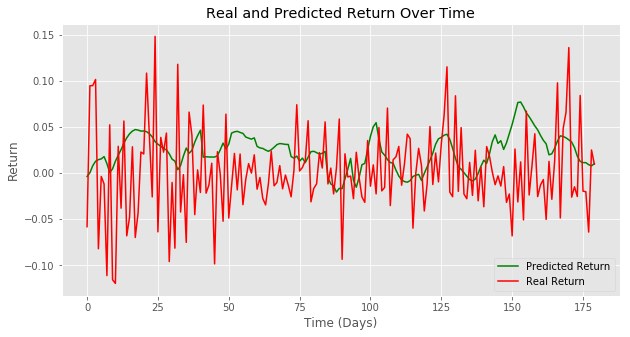

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:340: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:294: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.058028       -0.003693                -10   
2018-11-26     0.094647        0.000450                 10   
2018-11-27     0.094796        0.007985                 10   
2018-11-28     0.101435        0.012822                 10   
2018-11-29    -0.081898        0.014583                -10   
2018-11-30    -0.003578        0.015420                 -1   
2018-12-01    -0.011763        0.017912                 -5   
2018-12-02    -0.111014        0.010349                -10   
2018-12-03     0.052290        0.000583                 10   
2018-12-04    -0.115457        0.004693                -10   
2018-12-05    -0.119473        0.012901                -10   
2018-12-06     0.029063        0.019386                 10   
2018-12-07    -0.037935        0.025452                -10   
2018-12-08     0.056453        0.032493                 10   
2018-12-

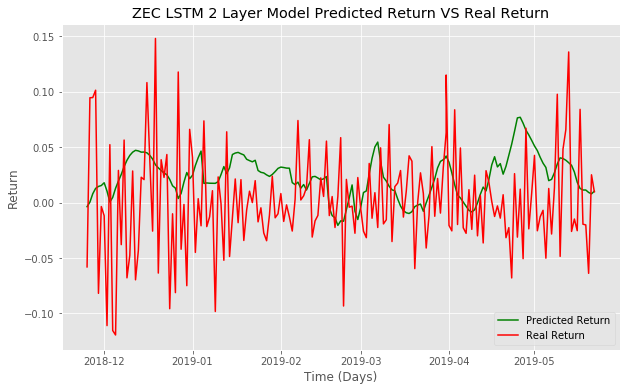

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

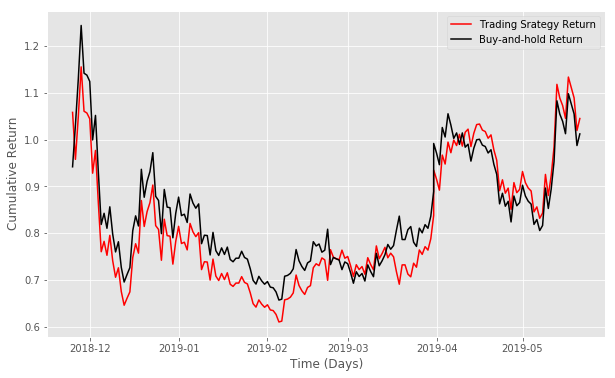

Annulized Sharpe Ratio is -0.2301973374405903
Annulized Sharpe Ratio for buy and hold strategy is -0.2905846972302419


In [8]:
#Compile together
#ZEC
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_ZEC-USD.csv", 30, 0.7808)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("ZEC LSTM 2 Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

classification.head(10)
test_set=pd.DataFrame(classification['real_y_predict_range'])
type(test_set)
test_set.columns=['classification_predict']
test_set['Price']=dataset_total['Adj Close'][line:]
test_set['Position']=0

for i in range(test_set.shape[0]):
    if test_set['classification_predict'][i]<0:
        test_set['Position'][i]=-1
    elif test_set['classification_predict'][i]==0:
        test_set['Position'][i]=test_set['Position'][i-1]
    else:
        test_set['Position'][i]=1
test_set['daily_return']=test_set['Price'].pct_change()
test_set['daily_return']=test_set['daily_return'].shift(-1)
test_set['strategy_daily_return']=test_set['Position']*test_set['daily_return']
test_set=test_set.dropna()
test_set['buy_cumulative_return']=1
test_set=test_set.dropna()
test_set['buy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['buy_cumulative_return'][i]=test_set['daily_return'][i]+1
    else:
        test_set['buy_cumulative_return'][i]=(test_set['daily_return'][i]+1)* test_set['buy_cumulative_return'][i-1]

test_set['strategy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['strategy_cumulative_return'][i]=test_set['strategy_daily_return'][i]+1
    else:
        test_set['strategy_cumulative_return'][i]=(test_set['strategy_daily_return'][i]+1)* test_set['strategy_cumulative_return'][i-1]

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
plt.plot(test_set['strategy_cumulative_return'], color='red', label = 'Trading Srategy Return')
plt.plot(test_set['buy_cumulative_return'], color='black', label = 'Buy-and-hold Return')
plt.ylabel("Cumulative Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

#calculate trading strategy sharpe ratio
risk_free_rate=0.002

test_set['excess_return']=test_set['strategy_daily_return']-risk_free_rate
test_set['excess_return'].std()
test_set['excess_return'].mean()
daily_sharpe=test_set['excess_return'].mean()/test_set['excess_return'].std()
print('Annulized Sharpe Ratio is '+str(daily_sharpe*252**0.5))

#calculate buy and hold sharpe ratio
test_set['excess_return_buy']=test_set['daily_return']-risk_free_rate
test_set['excess_return_buy'].std()
test_set['excess_return_buy'].mean()
daily_sharpe_2=test_set['excess_return_buy'].mean()/test_set['excess_return_buy'].std()
print('Annulized Sharpe Ratio for buy and hold strategy is '+str(daily_sharpe_2*252**0.5))

Sharpe=pd.DataFrame(test_set['excess_return_buy'])
Sharpe['excess_return_str']=test_set['excess_return']

####rename for each cryptocurrency
Sharpe.to_csv('Sharpe_LSTM2_ZEC.csv')

(396, 30, 98)
(396,)
(180, 30, 98)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 30, 32)            16768     
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 25,121
Trainable params: 25,121
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 277 samples, validate on 119 samples
Epoch 1/100
277/277 [==============================] - 3s 9ms/step - loss: 0.0693 - val_loss: 0.0066
Epoch 2/100
277/277 [==============================] - 0s 722us/step - loss: 0.0356 - val_loss: 0.0076
Epoch 3/100
277/277 [==============================] - 0s 787us/step - loss: 0.0258 - val_loss: 0.0061
Epoch 4/100
277/277 [==============================] - 0s 826us/step - loss: 0.0245 - val_loss: 0.0066
Epoch 5/100
277/277 [==============================] - 0s 779us/step - loss: 0.0276 - val_loss: 0.0067
Epoch 6/100
277/277 [==============================] - 0s 733us/step - loss: 0.0277 - val_loss: 0.0075
Epoch 7/100
277/277 [==============================] - 0s 836us/step - loss: 0.0255 - val_loss: 0.0059
Epoch 8/100
277/277 [==============================] - 0s 805us/step - loss: 0.0247 - val_loss: 0.0064
Epoch 9/100
277/277 [==============================] - 0s 810us/step - loss: 0.0234 - val_loss: 0.0059
Epoch 10/100
277/277 [=======

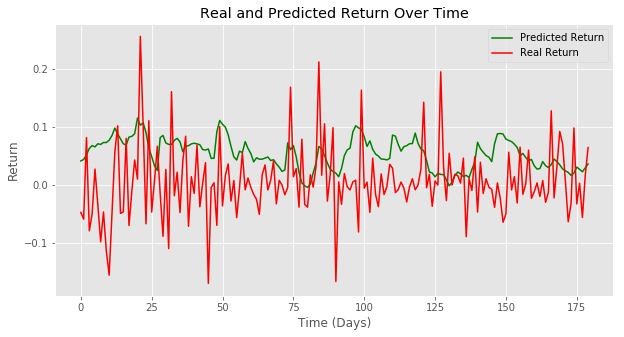

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

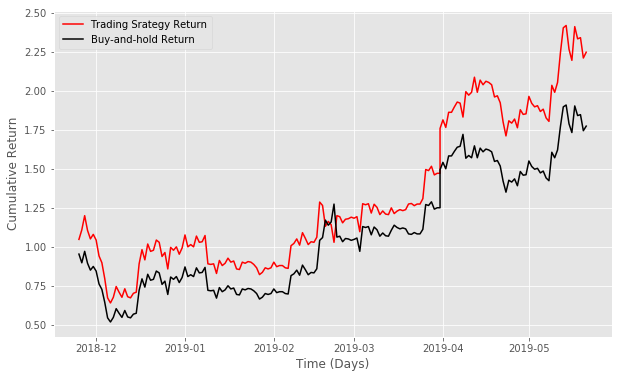

Annulized Sharpe Ratio is 1.1237658410186087
Annulized Sharpe Ratio for buy and hold strategy is 0.7832429664222199


In [9]:
#Compile together
#EOS 
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_EOS-USD.csv", 30, 0.6880)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification.head(10)
test_set=pd.DataFrame(classification['real_y_predict_range'])
type(test_set)
test_set.columns=['classification_predict']
test_set['Price']=dataset_total['Adj Close'][line:]
test_set['Position']=0

for i in range(test_set.shape[0]):
    if test_set['classification_predict'][i]<0:
        test_set['Position'][i]=-1
    elif test_set['classification_predict'][i]==0:
        test_set['Position'][i]=test_set['Position'][i-1]
    else:
        test_set['Position'][i]=1
test_set['daily_return']=test_set['Price'].pct_change()
test_set['daily_return']=test_set['daily_return'].shift(-1)
test_set['strategy_daily_return']=test_set['Position']*test_set['daily_return']
test_set=test_set.dropna()
test_set['buy_cumulative_return']=1
test_set=test_set.dropna()
test_set['buy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['buy_cumulative_return'][i]=test_set['daily_return'][i]+1
    else:
        test_set['buy_cumulative_return'][i]=(test_set['daily_return'][i]+1)* test_set['buy_cumulative_return'][i-1]

test_set['strategy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['strategy_cumulative_return'][i]=test_set['strategy_daily_return'][i]+1
    else:
        test_set['strategy_cumulative_return'][i]=(test_set['strategy_daily_return'][i]+1)* test_set['strategy_cumulative_return'][i-1]

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
plt.plot(test_set['strategy_cumulative_return'], color='red', label = 'Trading Srategy Return')
plt.plot(test_set['buy_cumulative_return'], color='black', label = 'Buy-and-hold Return')
plt.ylabel("Cumulative Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

#calculate trading strategy sharpe ratio
risk_free_rate=0.002

test_set['excess_return']=test_set['strategy_daily_return']-risk_free_rate
test_set['excess_return'].std()
test_set['excess_return'].mean()
daily_sharpe=test_set['excess_return'].mean()/test_set['excess_return'].std()
print('Annulized Sharpe Ratio is '+str(daily_sharpe*252**0.5))

#calculate buy and hold sharpe ratio
test_set['excess_return_buy']=test_set['daily_return']-risk_free_rate
test_set['excess_return_buy'].std()
test_set['excess_return_buy'].mean()
daily_sharpe_2=test_set['excess_return_buy'].mean()/test_set['excess_return_buy'].std()
print('Annulized Sharpe Ratio for buy and hold strategy is '+str(daily_sharpe_2*252**0.5))

Sharpe=pd.DataFrame(test_set['excess_return_buy'])
Sharpe['excess_return_str']=test_set['excess_return']

####rename for each cryptocurrency
Sharpe.to_csv('Sharpe_LSTM2_EOS.csv')

(1088, 30, 110)
(1088,)
(180, 30, 110)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 30, 32)            18304     
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 26,657
Trainable params: 26,657
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 761 samples, validate on 327 samples
Epoch 1/100
761/761 [==============================] - 3s 4ms/step - loss: 0.0218 - val_loss: 0.0184
Epoch 2/100
761/761 [==============================] - 1s 752us/step - loss: 0.0136 - val_loss: 0.0063
Epoch 3/100
761/761 [==============================] - 1s 760us/step - loss: 0.0136 - val_loss: 0.0143
Epoch 4/100
761/761 [==============================] - 1s 755us/step - loss: 0.0141 - val_loss: 0.0064
Epoch 5/100
761/761 [==============================] - 1s 772us/step - loss: 0.0128 - val_loss: 0.0072
Epoch 6/100
761/761 [==============================] - 1s 792us/step - loss: 0.0126 - val_loss: 0.0075
Epoch 7/100
761/761 [==============================] - 1s 772us/step - loss: 0.0118 - val_loss: 0.0058
Epoch 8/100
761/761 [==============================] - 1s 772us/step - loss: 0.0117 - val_loss: 0.0071
Epoch 9/100
761/761 [==============================] - 1s 765us/step - loss: 0.0116 - val_loss: 0.0064
Epoch 10/100
761/761 [=======

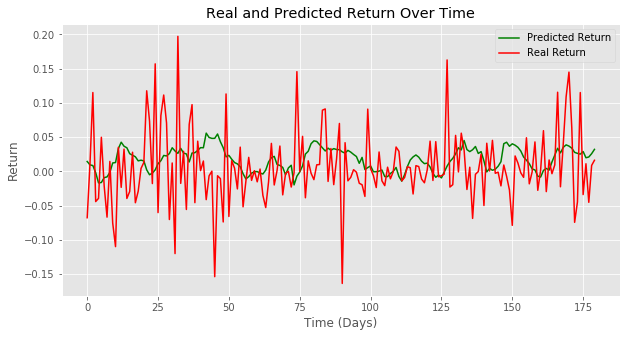

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:328: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:340: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

            real_y_test  real_y_predict  real_y_test_range  \
Date                                                         
2018-11-25    -0.067495        0.014537                -10   
2018-11-26     0.012125        0.009591                  6   
2018-11-27     0.115165        0.008627                 10   
2018-11-28    -0.043945       -0.001794                -10   
2018-11-29    -0.039241       -0.016650                -10   
2018-11-30     0.049880       -0.016116                 10   
2018-12-01    -0.021435       -0.008965                -10   
2018-12-02    -0.066661       -0.007959                -10   
2018-12-03     0.014691       -0.001494                  7   
2018-12-04    -0.075123        0.012399                -10   
2018-12-05    -0.109678        0.013034                -10   
2018-12-06     0.035165        0.033335                 10   
2018-12-07    -0.023181        0.042696                -10   
2018-12-08     0.032590        0.036814                 10   
2018-12-

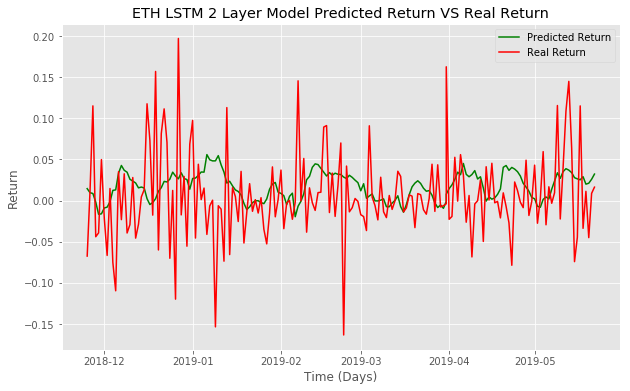

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

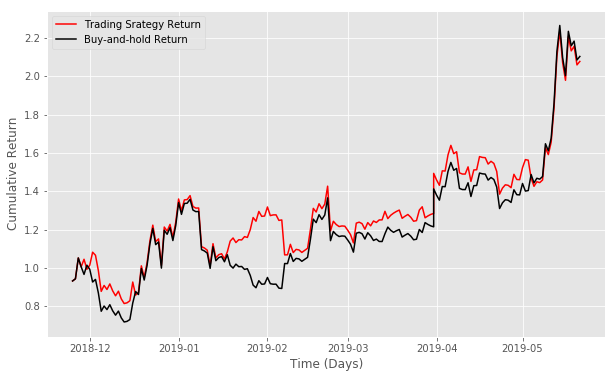

Annulized Sharpe Ratio is 1.0395769431727633
Annulized Sharpe Ratio for buy and hold strategy is 1.056727261539883


In [10]:
#Compile together
#ETH 
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore,line= load_data("merge_ETH-USD.csv", 30, 0.8582)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

classification=pd.DataFrame({'real_y_test':real_y_test,'real_y_predict':real_y_predict.reshape(real_y_test.shape[0],)})
classification.index=dataset_total.index[line:]

classify_range('real_y_test')
classify_range('real_y_predict')

print(classification)

successful_rate=find_the_successful_rate(classification)

print("Successful prediction rate is "+str(successful_rate))

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
ax.set_title("ETH LSTM 2 Layer Model Predicted Return VS Real Return")
plt.plot(classification['real_y_predict'], color='green', label = 'Predicted Return')
plt.plot(classification['real_y_test'], color='red', label = 'Real Return')
plt.ylabel("Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

classification.head(10)
test_set=pd.DataFrame(classification['real_y_predict_range'])
type(test_set)
test_set.columns=['classification_predict']
test_set['Price']=dataset_total['Adj Close'][line:]
test_set['Position']=0

for i in range(test_set.shape[0]):
    if test_set['classification_predict'][i]<0:
        test_set['Position'][i]=-1
    elif test_set['classification_predict'][i]==0:
        test_set['Position'][i]=test_set['Position'][i-1]
    else:
        test_set['Position'][i]=1
test_set['daily_return']=test_set['Price'].pct_change()
test_set['daily_return']=test_set['daily_return'].shift(-1)
test_set['strategy_daily_return']=test_set['Position']*test_set['daily_return']
test_set=test_set.dropna()
test_set['buy_cumulative_return']=1
test_set=test_set.dropna()
test_set['buy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['buy_cumulative_return'][i]=test_set['daily_return'][i]+1
    else:
        test_set['buy_cumulative_return'][i]=(test_set['daily_return'][i]+1)* test_set['buy_cumulative_return'][i-1]

test_set['strategy_cumulative_return']=float(0)
for i in range(test_set.shape[0]):
    if i<=0:
        test_set['strategy_cumulative_return'][i]=test_set['strategy_daily_return'][i]+1
    else:
        test_set['strategy_cumulative_return'][i]=(test_set['strategy_daily_return'][i]+1)* test_set['strategy_cumulative_return'][i-1]

fig_n = plt.figure(figsize=(10, 6))
ax = fig_n.add_subplot(111)
plt.plot(test_set['strategy_cumulative_return'], color='red', label = 'Trading Srategy Return')
plt.plot(test_set['buy_cumulative_return'], color='black', label = 'Buy-and-hold Return')
plt.ylabel("Cumulative Return")
plt.xlabel("Time (Days)")
ax.legend()
plt.style.use('ggplot')
plt.show()

#calculate trading strategy sharpe ratio
risk_free_rate=0.002

test_set['excess_return']=test_set['strategy_daily_return']-risk_free_rate
test_set['excess_return'].std()
test_set['excess_return'].mean()
daily_sharpe=test_set['excess_return'].mean()/test_set['excess_return'].std()
print('Annulized Sharpe Ratio is '+str(daily_sharpe*252**0.5))

#calculate buy and hold sharpe ratio
test_set['excess_return_buy']=test_set['daily_return']-risk_free_rate
test_set['excess_return_buy'].std()
test_set['excess_return_buy'].mean()
daily_sharpe_2=test_set['excess_return_buy'].mean()/test_set['excess_return_buy'].std()
print('Annulized Sharpe Ratio for buy and hold strategy is '+str(daily_sharpe_2*252**0.5))

Sharpe=pd.DataFrame(test_set['excess_return_buy'])
Sharpe['excess_return_str']=test_set['excess_return']

####rename for each cryptocurrency
Sharpe.to_csv('Sharpe_LSTM2_ETH.csv')